# 🔧 环境配置和检查

## 概述
本教程需要特定的环境配置以确保最佳学习体验。以下配置将帮助您：
- 使用统一的conda环境
- 通过国内镜像源快速安装依赖
- 加速模型下载
- 检查系统配置

## 配置步骤
1. **Conda环境管理** - 激活统一的学习环境
2. **包管理器优化** - 配置pip使用清华镜像源
3. **模型下载加速** - 设置HuggingFace镜像代理
4. **系统环境诊断** - 检查硬件和软件配置


In [ ]:
# 1. 激活conda环境
%%script bash
# 初始化 conda
eval "$(conda shell.bash hook)"
conda activate flyai_agent_in_action
conda env list


In [ ]:
# 2. 设置pip 为清华源
%pip config set global.index-url https://pypi.tuna.tsinghua.edu.cn/simple
%pip config list


In [ ]:
# 3. 设置HuggingFace代理
%env HF_ENDPOINT=https://hf-mirror.com
# 验证：使用shell命令检查
!echo $HF_ENDPOINT

In [ ]:
# 🔍 环境信息检查脚本
#
# 本脚本的作用：
# 1. 安装 pandas 库用于数据表格展示
# 2. 检查系统的各项配置信息
# 3. 生成详细的环境报告表格
#
# 对于初学者来说，这个步骤帮助您：
# - 了解当前运行环境的硬件配置
# - 确认是否满足模型运行的最低要求
# - 学习如何通过代码获取系统信息

# 安装 pandas 库 - 用于创建和展示数据表格
# pandas 是 Python 中最流行的数据处理和分析库
%pip install pandas==2.2.2 tabulate==0.9.0

import platform # 导入 platform 模块以获取系统信息
import os # 导入 os 模块以与操作系统交互
import subprocess # 导入 subprocess 模块以运行外部命令
import pandas as pd # 导入 pandas 模块，通常用于数据处理，这里用于创建表格
import shutil # 导入 shutil 模块以获取磁盘空间信息

# 获取 CPU 信息的函数，包括核心数量
def get_cpu_info():
    cpu_info = "" # 初始化 CPU 信息字符串
    physical_cores = "N/A"
    logical_cores = "N/A"

    if platform.system() == "Windows": # 如果是 Windows 系统
        cpu_info = platform.processor() # 使用 platform.processor() 获取 CPU 信息
        try:
            # 获取 Windows 上的核心数量 (需要 WMI)
            import wmi
            c = wmi.WMI()
            for proc in c.Win32_Processor():
                physical_cores = proc.NumberOfCores
                logical_cores = proc.NumberOfLogicalProcessors
        except:
            pass # 如果 WMI 不可用，忽略错误

    elif platform.system() == "Darwin": # 如果是 macOS 系统
        # 在 macOS 上使用 sysctl 命令获取 CPU 信息和核心数量
        os.environ['PATH'] = os.environ['PATH'] + os.pathsep + '/usr/sbin' # 更新 PATH 环境变量
        try:
            process_brand = subprocess.Popen(['sysctl', "machdep.cpu.brand_string"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout_brand, stderr_brand = process_brand.communicate()
            cpu_info = stdout_brand.decode().split(': ')[1].strip() if stdout_brand else "Could not retrieve CPU info"

            process_physical = subprocess.Popen(['sysctl', "hw.physicalcpu"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout_physical, stderr_physical = process_physical.communicate()
            physical_cores = stdout_physical.decode().split(': ')[1].strip() if stdout_physical else "N/A"

            process_logical = subprocess.Popen(['sysctl', "hw.logicalcpu"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout_logical, stderr_logical = process_logical.communicate()
            logical_cores = stdout_logical.decode().split(': ')[1].strip() if stdout_logical else "N/A"

        except:
            cpu_info = "Could not retrieve CPU info"
            physical_cores = "N/A"
            logical_cores = "N/A"

    else:  # Linux 系统
        try:
            # 在 Linux 上读取 /proc/cpuinfo 文件获取 CPU 信息和核心数量
            with open('/proc/cpuinfo') as f:
                physical_cores_count = 0
                logical_cores_count = 0
                cpu_info_lines = []
                for line in f:
                    if line.startswith('model name'): # 查找以 'model name'开头的行
                        if not cpu_info: # 只获取第一个 model name
                            cpu_info = line.split(': ')[1].strip()
                    elif line.startswith('cpu cores'): # 查找以 'cpu cores' 开头的行
                        physical_cores_count = int(line.split(': ')[1].strip())
                    elif line.startswith('processor'): # 查找以 'processor' 开头的行
                        logical_cores_count += 1
                physical_cores = str(physical_cores_count) if physical_cores_count > 0 else "N/A"
                logical_cores = str(logical_cores_count) if logical_cores_count > 0 else "N/A"
                if not cpu_info:
                     cpu_info = "Could not retrieve CPU info"

        except:
            cpu_info = "Could not retrieve CPU info"
            physical_cores = "N/A"
            logical_cores = "N/A"

    return f"{cpu_info} ({physical_cores} physical cores, {logical_cores} logical cores)" # 返回 CPU 信息和核心数量


# 获取内存信息的函数
def get_memory_info():
    mem_info = "" # 初始化内存信息字符串
    if platform.system() == "Windows":
        # 在 Windows 上不容易通过标准库获取，需要外部库或 PowerShell
        mem_info = "Requires external tools on Windows" # 设置提示信息
    elif platform.system() == "Darwin": # 如果是 macOS 系统
        # 在 macOS 上使用 sysctl 命令获取内存大小
        process = subprocess.Popen(['sysctl', "hw.memsize"], stdout=subprocess.PIPE, stderr=subprocess.PIPE) # 运行 sysctl 命令
        stdout, stderr = process.communicate() # 获取标准输出和标准错误
        mem_bytes = int(stdout.decode().split(': ')[1].strip()) # 解析输出，获取内存大小（字节）
        mem_gb = mem_bytes / (1024**3) # 转换为 GB
        mem_info = f"{mem_gb:.2f} GB" # 格式化输出
    else:  # Linux 系统
        try:
            # 在 Linux 上读取 /proc/meminfo 文件获取内存信息
            with open('/proc/meminfo') as f:
                total_mem_kb = 0
                available_mem_kb = 0
                for line in f:
                    if line.startswith('MemTotal'): # 查找以 'MemTotal' 开头的行
                        total_mem_kb = int(line.split(':')[1].strip().split()[0]) # 解析行，获取总内存（KB）
                    elif line.startswith('MemAvailable'): # 查找以 'MemAvailable' 开头的行
                         available_mem_kb = int(line.split(':')[1].strip().split()[0]) # 解析行，获取可用内存（KB）

                if total_mem_kb > 0:
                    total_mem_gb = total_mem_kb / (1024**2) # 转换为 GB
                    mem_info = f"{total_mem_gb:.2f} GB" # 格式化输出总内存
                    if available_mem_kb > 0:
                        available_mem_gb = available_mem_kb / (1024**2)
                        mem_info += f" (Available: {available_mem_gb:.2f} GB)" # 添加可用内存信息
                else:
                     mem_info = "Could not retrieve memory info" # 如果读取文件出错，设置错误信息

        except:
            mem_info = "Could not retrieve memory info" # 如果读取文件出错，设置错误信息
    return mem_info # 返回内存信息

# 获取 GPU 信息的函数，包括显存
def get_gpu_info():
    try:
        # 尝试使用 nvidia-smi 获取 NVIDIA GPU 信息和显存
        result = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total', '--format=csv,noheader'], capture_output=True, text=True)
        if result.returncode == 0: # 如果命令成功执行
            gpu_lines = result.stdout.strip().split('\n') # 解析输出，获取 GPU 名称和显存
            gpu_info_list = []
            for line in gpu_lines:
                name, memory = line.split(', ')
                gpu_info_list.append(f"{name} ({memory})") # 格式化 GPU 信息
            return ", ".join(gpu_info_list) if gpu_info_list else "NVIDIA GPU found, but info not listed" # 返回 GPU 信息或提示信息
        else:
             # 尝试使用 lshw 获取其他 GPU 信息 (需要安装 lshw)
            try:
                result_lshw = subprocess.run(['lshw', '-C', 'display'], capture_output=True, text=True)
                if result_lshw.returncode == 0: # 如果命令成功执行
                     # 简单解析输出中的 product 名称和显存
                    gpu_info_lines = []
                    current_gpu = {}
                    for line in result_lshw.stdout.splitlines():
                        if 'product:' in line:
                             if current_gpu:
                                 gpu_info_lines.append(f"{current_gpu.get('product', 'GPU')} ({current_gpu.get('memory', 'N/A')})")
                             current_gpu = {'product': line.split('product:')[1].strip()}
                        elif 'size:' in line and 'memory' in line:
                             current_gpu['memory'] = line.split('size:')[1].strip()

                    if current_gpu: # 添加最后一个 GPU 的信息
                        gpu_info_lines.append(f"{current_gpu.get('product', 'GPU')} ({current_gpu.get('memory', 'N/A')})")

                    return ", ".join(gpu_info_lines) if gpu_info_lines else "GPU found (via lshw), but info not parsed" # 如果找到 GPU 但信息无法解析，设置提示信息
                else:
                    return "No GPU found (checked nvidia-smi and lshw)" # 如果两个命令都找不到 GPU，设置提示信息
            except FileNotFoundError:
                 return "No GPU found (checked nvidia-smi, lshw not found)" # 如果找不到 lshw 命令，设置提示信息
    except FileNotFoundError:
        return "No GPU found (nvidia-smi not found)" # 如果找不到 nvidia-smi 命令，设置提示信息


# 获取 CUDA 版本的函数
def get_cuda_version():
    try:
        # 尝试使用 nvcc --version 获取 CUDA 版本
        result = subprocess.run(['nvcc', '--version'], capture_output=True, text=True)
        if result.returncode == 0: # 如果命令成功执行
            for line in result.stdout.splitlines():
                if 'release' in line: # 查找包含 'release' 的行
                    return line.split('release ')[1].split(',')[0] # 解析行，提取版本号
        return "CUDA not found or version not parsed" # 如果找不到 CUDA 或版本无法解析，设置提示信息
    except FileNotFoundError:
        return "CUDA not found" # 如果找不到 nvcc 命令，设置提示信息

# 获取 Python 版本的函数
def get_python_version():
    return platform.python_version() # 获取 Python 版本

# 获取 Conda 版本的函数
def get_conda_version():
    try:
        # 尝试使用 conda --version 获取 Conda 版本
        result = subprocess.run(['conda', '--version'], capture_output=True, text=True)
        if result.returncode == 0: # 如果命令成功执行
            return result.stdout.strip() # 返回 Conda 版本
        return "Conda not found or version not parsed" # 如果找不到 Conda 或版本无法解析，设置提示信息
    except FileNotFoundError:
        return "Conda not found" # 如果找不到 conda 命令，设置提示信息

# 获取物理磁盘空间信息的函数
def get_disk_space():
    try:
        total, used, free = shutil.disk_usage("/") # 获取根目录的磁盘使用情况
        total_gb = total / (1024**3) # 转换为 GB
        used_gb = used / (1024**3) # 转换为 GB
        free_gb = free / (1024**3) # 转换为 GB
        return f"Total: {total_gb:.2f} GB, Used: {used_gb:.2f} GB, Free: {free_gb:.2f} GB" # 格式化输出
    except Exception as e:
        return f"Could not retrieve disk info: {e}" # 如果获取信息出错，设置错误信息

# 获取环境信息
os_name = platform.system() # 获取操作系统名称
os_version = platform.release() # 获取操作系统版本
if os_name == "Linux":
    try:
        # 在 Linux 上尝试获取发行版和版本
        lsb_info = subprocess.run(['lsb_release', '-a'], capture_output=True, text=True)
        if lsb_info.returncode == 0: # 如果命令成功执行
            for line in lsb_info.stdout.splitlines():
                if 'Description:' in line: # 查找包含 'Description:' 的行
                    os_version = line.split('Description:')[1].strip() # 提取描述信息作为版本
                    break # 找到后退出循环
                elif 'Release:' in line: # 查找包含 'Release:' 的行
                     os_version = line.split('Release:')[1].strip() # 提取版本号
                     # 尝试获取 codename
                     try:
                         codename_info = subprocess.run(['lsb_release', '-c'], capture_output=True, text=True)
                         if codename_info.returncode == 0:
                             os_version += f" ({codename_info.stdout.split(':')[1].strip()})" # 将 codename 添加到版本信息中
                     except:
                         pass # 如果获取 codename 失败则忽略

    except FileNotFoundError:
        pass # lsb_release 可能未安装，忽略错误

full_os_info = f"{os_name} {os_version}" # 组合完整的操作系统信息
cpu_info = get_cpu_info() # 调用函数获取 CPU 信息和核心数量
memory_info = get_memory_info() # 调用函数获取内存信息
gpu_info = get_gpu_info() # 调用函数获取 GPU 信息和显存
cuda_version = get_cuda_version() # 调用函数获取 CUDA 版本
python_version = get_python_version() # 调用函数获取 Python 版本
conda_version = get_conda_version() # 调用函数获取 Conda 版本
disk_info = get_disk_space() # 调用函数获取物理磁盘空间信息


# 创建用于存储数据的字典
env_data = {
    "项目": [ # 项目名称列表
        "操作系统",
        "CPU 信息",
        "内存信息",
        "GPU 信息",
        "CUDA 信息",
        "Python 版本",
        "Conda 版本",
        "物理磁盘空间" # 添加物理磁盘空间
    ],
    "信息": [ # 对应的信息列表
        full_os_info,
        cpu_info,
        memory_info,
        gpu_info,
        cuda_version,
        python_version,
        conda_version,
        disk_info # 添加物理磁盘空间信息
    ]
}

# 创建一个 pandas DataFrame
df = pd.DataFrame(env_data)

# 打印表格
print("### 环境信息") # 打印标题
print(df.to_markdown(index=False)) # 将 DataFrame 转换为 Markdown 格式并打印，不包含索引


<a href="https://colab.research.google.com/github/FlyAIBox/langchain-academy/blob/fly101/module-3/streaming-interruption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 流式处理 (Streaming)

## 回顾

在模块2中，我们学习了自定义图状态和内存的几种方法。

我们构建了一个具有外部内存的聊天机器人，能够维持长时间的对话。

## 学习目标

本模块将深入探讨"人机协同"(human-in-the-loop)技术，该技术基于内存机制，允许用户以各种方式直接与图进行交互。

为了为"人机协同"技术奠定基础，我们将首先学习流式处理，它提供了多种方式来可视化图在执行过程中的输出（例如，节点状态或聊天模型的token）。

### 流式处理的重要性
- **实时反馈**：用户可以实时看到AI的思考和生成过程
- **更好的用户体验**：避免长时间等待，提供即时响应
- **调试和监控**：开发者可以观察图的执行流程和状态变化
- **交互式应用**：支持更自然的对话式交互体验

In [1]:
%%capture --no-stderr
# %pip install --quiet -U langgraph langchain_openai langgraph_sdk
%pip install --quiet langgraph==0.6.7 langchain_openai==0.3.32 langgraph_sdk==0.2.6

## 流式处理基础

LangGraph 内置了[一流的流式处理支持](https://langchain-ai.github.io/langgraph/concepts/low_level/#streaming)。

让我们设置来自模块2的聊天机器人，并展示在图执行过程中流式输出结果的各种方法。

### 流式处理的核心概念
- **状态流式传输**：实时传输图的状态变化
- **Token流式传输**：逐token传输大语言模型的生成内容
- **事件流式传输**：传输图执行过程中的各种事件
- **消息流式传输**：专门针对消息列表的流式处理

In [2]:
import os, getpass

def _set_env(var: str):
    """
    安全地设置环境变量
    如果环境变量不存在，则提示用户输入

    Args:
        var (str): 要设置的环境变量名称
    """
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

# 设置OpenAI API密钥，这是使用GPT模型所必需的
_set_env("OPENAI_API_KEY")
# 设置 OpenAI API代理地址 (例如：https://api.apiyi.com/v1）
_set_env("OPENAI_BASE_URL")

OPENAI_API_KEY: ··········
OPENAI_BASE_URL: ··········


**重要提示**：我们使用 `RunnableConfig` 与 `call_model` 来启用逐token的流式传输。这在 [Python < 3.11 版本中是必需的](https://langchain-ai.github.io/langgraph/how-tos/streaming-tokens/)。我们包含这个配置是为了确保在Google Colab（使用Python 3.x）中也能正常运行。

### 为什么需要RunnableConfig？
- **兼容性**：确保在不同Python版本中的一致性行为
- **流式传输**：启用token级别的实时流式输出
- **配置管理**：统一管理运行时的各种配置参数
----
-----

### `RunnableConfig` 简介

`RunnableConfig` 是 LangChain 中一个关键的配置对象，它用于在调用可运行对象（`Runnable`）时传递运行时配置信息。这个配置对象提供了对整个执行链行为进行细粒度控制的能力，让你可以调整日志、回调、线程执行器等，而无需修改链本身的定义。

#### `RunnableConfig` 接收的内容和功能

`RunnableConfig` 本质上是一个字典，它可以接收以下常用参数：

  * **`callbacks`**: 这是一个回调处理程序（`CallbackHandler`）列表。你可以通过它来监听和记录整个链中发生的事件，例如每次 LLM 调用、工具调用或整个链的开始和结束。这对于调试、监控和日志记录非常有用。
  * **`tags`**: 标签列表，可以用来标记和分类你的运行。这在跟踪和分析大量运行日志时特别有用，你可以根据标签过滤和查询特定的运行。
  * **`metadata`**: 包含额外元数据的字典。这些元数据会附加到运行中，可以用于存储任何自定义信息，例如用户信息、任务 ID 或其他业务相关数据。
  * **`max_concurrency`**: 设置链中可并行执行的最大任务数。这有助于控制资源使用，避免过多的并发请求。
  * **`recursion_limit`**: 递归调用的最大深度。主要用于防止递归循环，在像 Agent 这样的复杂应用中尤为重要。
  * **`configurable`**: 包含可配置参数的字典。它允许你在运行时动态地配置链中的某些部分，例如，在不同环境中切换不同的 LLM 模型或工具。

#### 应用场景

`RunnableConfig` 的灵活性使其在多种场景下都非常有用：

  * **调试和监控**: 在开发和测试阶段，你可以使用 `callbacks` 来实时打印每一步的执行情况，帮助你理解和调试复杂的链。
  * **A/B 测试**: 通过 `configurable` 参数，你可以轻松地在不同运行中切换 LLM 模型或提示词，从而进行 A/B 测试来评估不同配置的效果。
  * **多租户应用**: 在一个多用户系统中，你可以将用户 ID 或租户信息添加到 `metadata` 中，以便于按用户追踪和分析其使用情况。
  * **资源控制**: 对于需要处理大量并发请求的生产环境，你可以使用 `max_concurrency` 来限制并行度，防止系统过载。
  * **个性化**: 不同的用户可能需要不同的配置，你可以通过 `configurable` 为每个用户动态加载其专属的设置。

-----

### 简单 Demo

下面是一个简单的示例，展示如何在 LangChain 表达式语言（LCEL）链中使用 `RunnableConfig`。

在这个例子中，我们将创建一个简单的链，它由一个带有自定义提示的 LLM 组成。我们将使用 `RunnableConfig` 来传递回调函数和标签。

```python
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnableConfig
from langchain_core.callbacks.base import BaseCallbackHandler
from typing import Any, Dict

# 1. 定义一个自定义的回调处理程序，用于打印 LLM 调用的详细信息
class MyCallbackHandler(BaseCallbackHandler):
    def on_llm_start(self, serialized: Dict[str, Any], prompts: list[str], **kwargs: Any) -> None:
        """Called when an LLM is about to be invoked."""
        print(f"--- LLM 调用开始 ---")
        print(f"提示词: {prompts[0]}")

    def on_llm_end(self, response: Any, **kwargs: Any) -> None:
        """Called when an LLM has finished running."""
        print(f"--- LLM 调用结束 ---")
        print(f"响应: {response.content}")

# 2. 定义一个简单的 LLM 链
prompt = PromptTemplate.from_template("告诉我一个关于 {topic} 的笑话。")
llm = ChatOpenAI(model="gpt-3.5-turbo")
chain = prompt | llm

# 3. 定义 RunnableConfig
# 我们将一个自定义回调和一些标签添加到配置中
config = RunnableConfig(
    callbacks=[MyCallbackHandler()],
    tags=["joke-chain", "demo"]
)

# 4. 在调用链时传递配置
result = chain.invoke({"topic": "狗"}, config=config)

print("\n--- 最终结果 ---")
print(result.content)
```

**运行结果：**

```
--- LLM 调用开始 ---
提示词: 告诉我一个关于 狗 的笑话。
--- LLM 调用结束 ---
响应: 为什么小狗老是绕着圈追自己的尾巴？
因为它很难把结尾连接起来！

--- 最终结果 ---
为什么小狗老是绕着圈追自己的尾巴？
因为它很难把结尾连接起来！
```

通过这个 demo，你可以看到 `RunnableConfig` 让我们在不改变链代码的情况下，通过传递配置对象来动态地注入行为（本例中的回调）。这让你的代码更加模块化和可维护。

-----

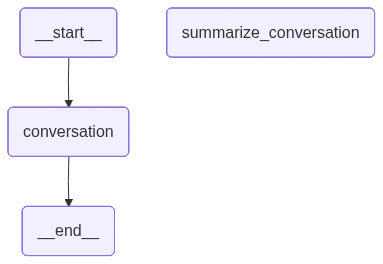

In [3]:
from IPython.display import Image, display

from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain_core.runnables import RunnableConfig

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState

# 初始化大语言模型
# 使用GPT-4o模型，temperature=0确保输出更加确定性和一致
model = ChatOpenAI(model="gpt-4o", temperature=0)

# 定义图的状态类
# 继承MessagesState，添加summary字段用于存储对话摘要
class State(MessagesState):
    summary: str  # 存储对话的摘要信息

def call_model(state: State, config: RunnableConfig):
    """
    调用大语言模型的核心函数

    这个函数负责：
    1. 检查是否存在对话摘要
    2. 如果有摘要，将其作为系统消息添加到对话中
    3. 调用LLM生成回复

    Args:
        state (State): 当前图的状态，包含消息列表和摘要
        config (RunnableConfig): 运行时配置，用于启用流式传输

    Returns:
        dict: 包含AI回复消息的字典
    """

    # 获取现有的对话摘要（如果存在）
    summary = state.get("summary", "")

    # 如果存在摘要，将其添加到对话中
    if summary:
        # 创建包含摘要的系统消息
        system_message = f"此前对话的摘要：{summary}"

        # 将摘要作为系统消息添加到消息列表的开头
        messages = [SystemMessage(content=system_message)] + state["messages"]

    else:
        # 如果没有摘要，直接使用原始消息
        messages = state["messages"]

    # 调用大语言模型生成回复
    response = model.invoke(messages, config)
    return {"messages": response}

def summarize_conversation(state: State):
    """
    对话摘要生成函数

    当对话消息过多时，此函数会：
    1. 生成对话摘要
    2. 删除除最近2条消息外的所有消息
    3. 保持对话的上下文连续性

    Args:
        state (State): 当前图的状态

    Returns:
        dict: 包含新摘要和要删除的消息的字典
    """

    # 获取现有的摘要（如果存在）
    summary = state.get("summary", "")

    # 根据是否存在现有摘要创建不同的提示词
    if summary:
        # 如果已有摘要，要求扩展现有摘要
        summary_message = (
          f"目前为止的对话摘要：{summary}\n\n"
          "请结合上方的新消息，扩展现有摘要："
      )

    else:
        # 如果没有摘要，创建新的摘要
        summary_message = "请对上方的对话创建摘要："

    # 将摘要提示添加到消息历史中
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)

    # 删除除最近2条消息外的所有消息，保持对话简洁
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

def should_continue(state: State):
    """
    决定图执行流程的函数

    根据对话长度决定下一步操作：
    - 如果消息超过6条，则进行摘要
    - 否则结束对话

    Args:
        state (State): 当前图的状态

    Returns:
        str: 下一个要执行的节点名称或END
    """

    messages = state["messages"]

    # 如果消息超过6条，触发对话摘要
    if len(messages) > 6:
        return "summarize_conversation"

    # 否则结束对话
    return END

# 构建LangGraph工作流
workflow = StateGraph(State)

# 添加节点：对话节点和摘要节点
workflow.add_node("conversation", call_model)  # 对话处理节点
workflow.add_node(summarize_conversation)      # 对话摘要节点

# 设置图的连接关系
workflow.add_edge(START, "conversation")                    # 从开始到对话节点
workflow.add_conditional_edges("conversation", should_continue)  # 条件边：根据消息数量决定下一步
workflow.add_edge("summarize_conversation", END)            # 从摘要节点到结束

# 编译图并添加内存检查点
memory = MemorySaver()  # 创建内存保存器，用于持久化对话状态
graph = workflow.compile(checkpointer=memory)

# 显示图的Mermaid可视化
display(Image(graph.get_graph().draw_mermaid_png()))

### 流式传输完整状态

现在，让我们讨论[流式传输图状态](https://langchain-ai.github.io/langgraph/concepts/low_level/#streaming)的方法。

`.stream` 和 `.astream` 是用于流式返回结果的同步和异步方法。

LangGraph 支持几种[不同的流式模式](https://langchain-ai.github.io/langgraph/how-tos/stream-values/)来传输[图状态](https://langchain-ai.github.io/langgraph/how-tos/stream-values/)：

* `values`：在每个节点被调用后流式传输图的完整状态
* `updates`：在每个节点被调用后流式传输图状态的更新部分

![values_vs_updates.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbaf892d24625a201744e5_streaming1.png)

让我们看看 `stream_mode="updates"` 模式。

由于我们使用 `updates` 模式进行流式传输，我们只能看到图中节点运行后对状态的更新。

每个 `chunk` 都是一个字典，以 `node_name` 作为键，以更新后的状态作为值。

### 流式模式对比

| 模式 | 描述 | 适用场景 | 数据量 |
|------|------|----------|--------|
| `values` | 传输完整状态 | 需要完整上下文时 | 较大 |
| `updates` | 只传输状态变化 | 关注增量变化时 | 较小 |

### 初学者提示
- **values模式**：适合需要完整状态信息的场景，如调试或状态监控
- **updates模式**：适合实时更新UI或只关心变化部分的场景
- **性能考虑**：updates模式通常更高效，因为它只传输变化的数据

In [4]:
# 创建对话线程
# thread_id用于标识不同的对话会话，支持多用户并发
config = {"configurable": {"thread_id": "1"}}

# 开始对话并使用updates模式进行流式传输
# 这将实时显示每个节点执行后的状态更新
for chunk in graph.stream({"messages": [HumanMessage(content="您好! 我是FLY")]}, config, stream_mode="updates"):
    print(chunk)

{'conversation': {'messages': AIMessage(content='您好，FLY！有什么我可以帮助您的吗？', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 13, 'total_tokens': 26, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}, 'input_tokens': 0, 'output_tokens': 0, 'input_tokens_details': None}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_8458c98457', 'id': 'chatcmpl-CEoZYRmsLgonxBXJMXFSfW9YwkJF3', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--09794dcf-9950-4de2-afba-fbc36539d680-0', usage_metadata={'input_tokens': 13, 'output_tokens': 13, 'total_tokens': 26, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}}


现在让我们只打印状态更新，以便更清楚地看到流式传输的效果。

In [5]:
# 开始对话并美化打印消息
# 使用pretty_print()方法可以更清晰地显示消息内容
for chunk in graph.stream({"messages": [HumanMessage(content="您好! 我是FLY")]}, config, stream_mode="updates"):
    chunk['conversation']["messages"].pretty_print()

================================== Ai Message ==================================

您好，FLY！很高兴见到您。有什么我可以帮助您的吗？


现在，我们可以看看 `stream_mode="values"` 模式。

这是 `conversation` 节点被调用后图的`完整状态`。

### values模式的特点
- **完整状态**：包含图中所有字段的完整信息
- **历史记录**：可以看到所有历史消息和状态
- **调试友好**：便于开发者理解图的完整执行状态

In [6]:
# 重新开始对话，使用新的线程ID
config = {"configurable": {"thread_id": "2"}}

# 使用values模式进行流式传输
# 这将显示每次节点执行后的完整状态
input_message = HumanMessage(content="您好! 我是FLY")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    # 遍历并美化打印所有消息
    for m in event['messages']:
        m.pretty_print()
    print("---"*25)  # 分隔线，便于区分不同的状态更新

================================ Human Message =================================

您好! 我是FLY
---------------------------------------------------------------------------
================================ Human Message =================================

您好! 我是FLY
================================== Ai Message ==================================

您好，FLY！很高兴见到您。有什么我可以帮助您的吗？
---------------------------------------------------------------------------


### 流式传输Token

我们通常希望流式传输的不仅仅是图状态。

特别是对于聊天模型调用，流式传输生成的token是很常见的需求。

我们可以使用[`.astream_events`方法](https://langchain-ai.github.io/langgraph/how-tos/streaming-from-final-node/#stream-outputs-from-the-final-node)来实现这一点，该方法会流式返回节点内部发生的事件！

每个事件都是一个包含几个键的字典：

* `event`：正在发出的事件类型
* `name`：事件的名称
* `data`：与事件关联的数据
* `metadata`：包含`langgraph_node`，即发出事件的节点

让我们来看看具体实现。

### Token流式传输的优势
- **实时响应**：用户可以实时看到AI的思考过程
- **更好的用户体验**：避免长时间等待，提供即时反馈
- **调试便利**：开发者可以观察模型的生成过程
- **交互性强**：支持更自然的对话体验

In [15]:
# 创建新的对话线程
config = {"configurable": {"thread_id": "3"}}
input_message = HumanMessage(content="给我讲下AI Agent的学习路线")

# 使用astream_events方法流式传输事件
# version="v2"指定使用第二版API，提供更好的事件结构
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # 打印事件信息：节点名称、事件类型和事件名称
    print(f"Node: {event['metadata'].get('langgraph_node','')}. Type: {event['event']}. Name: {event['name']}")

Node: . Type: on_chain_start. Name: LangGraph
Node: conversation. Type: on_chain_start. Name: conversation
Node: conversation. Type: on_chat_model_start. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. N



> 备注：代码中`async`关键字下有红色的下划线（通常表示语法错误），但代码却可以正常执行。

**分析：**

1.  **内容：**
    * 代码使用了`async for`循环，这是一个异步迭代器。
    * 代码调用了`graph.astream_events`方法。从方法名来看，这是一个异步方法，返回一个异步生成器或异步迭代器。
    * `async`关键字下面的红色下划线，这是Jupyter Notebook或其集成环境（如VS Code的Jupyter插件）的**linter**（代码静态分析工具）发出的警告或错误提示。

2.  **报错原因（为什么会有红线）：**
    * 在Jupyter Notebook中，`async`关键字通常需要在顶级作用域内配合`await`使用，或者在`async def`定义的函数内部使用。直接在Cell的顶级作用域使用`async for`或`await`，有时会被linter误判为语法错误。
    * 然而，**Jupyter Notebook的内核（IPython）** 对`async`和`await`在顶级作用域的支持越来越好，尤其是在较新版本中。它能自动识别这种模式，并在后台创建一个临时的`async`函数来执行这段代码。
    * 因此，**红色下划线是linter的误报**，而不是Python解释器的真正语法错误。

3.  **正常执行原因：**
    * 正如上面所说，Jupyter Notebook（IPython内核）能够正确处理顶级`async for`和`await`语句。内核会默默地将用户的代码包装在一个异步上下文中执行，从而使得代码能够正常运行，并且打印出预期的事件信息。

**总结：**

代码没有问题。Jupyter Notebook中的红色下划线是**linter的误报**，这是Jupyter环境在处理顶级`async for`或`await`时的一个常见现象。代码能够正常执行，证明Python内核本身能够正确解析和运行这段异步代码。你可以忽略这个视觉上的警告。



### `on_chat_model_stream` 类型

关键点是，聊天模型生成的token具有 `on_chat_model_stream` 类型。

我们可以使用 `event['metadata']['langgraph_node']` 来选择要流式传输的节点。

我们可以使用 `event['data']` 来获取每个事件的实际数据，在这种情况下是一个 `AIMessageChunk`。

### 事件类型说明
- **`on_chat_model_stream`**：聊天模型正在生成token时触发
- **`on_chain_start/end`**：链或节点开始/结束时触发
- **`on_chat_model_start`**：聊天模型开始调用时触发

### 初学者理解要点
- 每个token都会触发一个独立的事件
- 可以通过事件类型过滤我们关心的事件
- `AIMessageChunk`包含部分生成的消息内容

In [17]:
# 指定要流式传输的节点
node_to_stream = 'conversation'
config = {"configurable": {"thread_id": "4"}}
input_message = HumanMessage(content="给我讲下AI Agent的学习路线")

# 流式传输指定节点的聊天模型token
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # 只获取特定节点的聊天模型token流
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        print(event["data"])

{'chunk': AIMessageChunk(content='', additional_kwargs={}, response_metadata={}, id='run--286b3a39-fc2b-4002-a33f-7ffb73ef6bbd', usage_metadata={'input_tokens': 0, 'output_tokens': 0, 'total_tokens': 0, 'input_token_details': {}, 'output_token_details': {}})}
{'chunk': AIMessageChunk(content='学习', additional_kwargs={}, response_metadata={}, id='run--286b3a39-fc2b-4002-a33f-7ffb73ef6bbd', usage_metadata={'input_tokens': 0, 'output_tokens': 0, 'total_tokens': 0, 'input_token_details': {}, 'output_token_details': {}})}
{'chunk': AIMessageChunk(content='如何', additional_kwargs={}, response_metadata={}, id='run--286b3a39-fc2b-4002-a33f-7ffb73ef6bbd', usage_metadata={'input_tokens': 0, 'output_tokens': 0, 'total_tokens': 0, 'input_token_details': {}, 'output_token_details': {}})}
{'chunk': AIMessageChunk(content='成为', additional_kwargs={}, response_metadata={}, id='run--286b3a39-fc2b-4002-a33f-7ffb73ef6bbd', usage_metadata={'input_tokens': 0, 'output_tokens': 0, 'total_tokens': 0, 'input_toke

如上所示，只需使用 `chunk` 键即可获取 `AIMessageChunk`。

### 数据提取说明
- **`event["data"]`**：包含完整的事件数据
- **`event["data"]["chunk"]`**：包含实际的AIMessageChunk对象
- **`chunk.content`**：包含当前token的文本内容

In [18]:
# 创建新的对话线程
config = {"configurable": {"thread_id": "5"}}
input_message = HumanMessage(content="给我讲下AI Agent的学习路线")

# 流式传输并实时显示token内容
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # 获取特定节点的聊天模型token
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        data = event["data"]
        # 打印token内容，用"|"分隔以便观察流式效果
        print(data["chunk"].content, end="|")

|学习|成为|一|名|AI| Agent|开发|者|或|研究|者|需要|掌|握|多|方面|的|知识|和|技能|。|以下|是|一个|可能|的|学习|路线|，|帮助|你|逐|步|深入|理解|和|应用|人工|智能|技术|：

|###| |1|.| **|基础|知识|**
|-| **|数学|基础|**|：|掌|握|线|性|代|数|、|微|积分|、|概率|论|和|统计|学|。这|些|数学|知识|是|理解|机器|学习|算法|的|基础|。
|-| **|编|程|技能|**|：|熟|练|掌|握|至少|一种|编|程|语言|，如|Python|，它|是|AI|和|机器|学习|领域|最|常|用|的|语言|。

|###| |2|.| **|计算|机|科学|基础|**
|-| **|数据|结构|与|算法|**|：|理解|基本|的数据|结构|（|如|数组|、|链|表|、|树|、|图|）|和|算法|（|如|排序|、|搜索|）。
|-| **|计算|机|科学|导|论|**|：|了解|计算|机|系统|的|基本|原|理|，包括|操作|系统|、|网络|和|数据库|。

|###| |3|.| **|机器|学习|基础|**
|-| **|机器|学习|概|念|**|：|学习|监督|学习|、|无|监督|学习|和|强化|学习|的|基本|概|念|。
|-| **|常|用|算法|**|：|掌|握|线|性|回|归|、|逻|辑|回|归|、|决|策|树|、|支持|向|量|机|、|K|-me|ans|等|基本|算法|。
|-| **|实践|经验|**|：|使用|Sc|ikit|-le|arn|等|库|进行|简单|的|机器|学习|项目|。

|###| |4|.| **|深|度|学习|**
|-| **|神|经|网络|基础|**|：|理解|神|经|网络|的|基本|结构|和|工作|原|理|。
|-| **|深|度|学习|框|架|**|：|学习|使用|Tensor|Flow|和|Py|Torch|等|深|度|学习|框|架|。
|-| **|卷|积|神|经|网络|（|CNN|）|和|循环|神|经|网络|（|R|NN|）|**|：|掌|握|这些|用于|图|像|和|序|列|数据|处理|的|网络|。

|###| |5|.| **|强化|学习|**
|-| **|基本|概|念|**|：|理解|强化|学习|的|基本|原|理|，如|马

### 使用LangGraph API进行流式处理

**⚠️ 重要说明**

自这些视频录制以来，我们已经更新了Studio，使其可以在本地运行并在浏览器中打开。这是现在运行Studio的首选方式（而不是使用视频中显示的桌面应用程序）。请参阅本地开发服务器的文档[这里](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server)和[这里](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server)。要启动本地开发服务器，请在此模块的`/studio`目录中的终端运行以下命令：

```
langgraph dev
```

您应该看到以下输出：
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

打开浏览器并导航到Studio UI：`https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`。

LangGraph API [支持编辑图状态](https://langchain-ai.github.io/langgraph/cloud/how-tos/human_in_the_loop_edit_state/#initial-invocation)。

### LangGraph API的优势
- **本地开发**：无需云端部署即可进行开发和测试
- **可视化界面**：通过Web界面直观地观察图执行过程
- **API文档**：自动生成的API文档便于集成
- **状态编辑**：支持在运行时编辑图状态，实现人机交互

In [ ]:
# 检查是否在Google Colab环境中运行
# LangGraph Studio目前不支持Google Colab环境
if 'google.colab' in str(get_ipython()):
    raise Exception("Unfortunately LangGraph Studio is currently not supported on Google Colab")

In [ ]:
from langgraph_sdk import get_client

# 本地开发服务器的URL
URL = "http://127.0.0.1:2024"
client = get_client(url=URL)

# 搜索所有托管的图（助手）
# 这将返回所有可用的LangGraph助手
assistants = await client.assistants.search()

让我们像之前一样[流式传输`values`](https://langchain-ai.github.io/langgraph/cloud/how-tos/stream_values/)。

### API流式传输的特点
- **统一接口**：通过API提供一致的流式传输体验
- **多模式支持**：支持values、updates、messages等多种流式模式
- **更好的错误处理**：API提供更完善的错误处理机制

In [ ]:
# 创建新的对话线程
thread = await client.threads.create()
# 输入消息
input_message = HumanMessage(content="Multiply 2 and 3")

# 使用API进行values模式的流式传输
async for event in client.runs.stream(thread["thread_id"],
                      assistant_id="agent",
                      input={"messages": [input_message]},
                      stream_mode="values"):
    print(event)

流式传输的对象包含：

* `event`：事件类型
* `data`：状态数据

### StreamPart对象结构
- **event**：标识事件类型（如"values"、"metadata"等）
- **data**：包含实际的状态数据或元数据

In [ ]:
from langchain_core.messages import convert_to_messages

# 创建新的对话线程
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")

# 流式传输并美化显示消息
async for event in client.runs.stream(thread["thread_id"], assistant_id="agent", input={"messages": [input_message]}, stream_mode="values"):
    # 获取消息列表
    messages = event.data.get('messages',None)
    if messages:
        # 转换并打印最新的消息
        print(convert_to_messages(messages)[-1])
    print('='*25)  # 分隔线

有一些新的流式模式仅通过API支持。

例如，我们可以[使用`messages`模式](https://langchain-ai.github.io/langgraph/cloud/how-tos/stream_messages/)来更好地处理上述情况！

此模式目前假设您的图中有一个`messages`键，它是一个消息列表。

使用`messages`模式发出的所有事件都有两个属性：

* `event`：事件的名称
* `data`：与事件关联的数据

### messages模式的优势
- **专门优化**：专门为消息列表设计的流式模式
- **更好的性能**：针对消息处理进行了优化
- **简化处理**：直接处理消息对象，无需额外转换

In [ ]:
# 创建新的对话线程
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")

# 使用messages模式进行流式传输
async for event in client.runs.stream(thread["thread_id"],
                                      assistant_id="agent",
                                      input={"messages": [input_message]},
                                      stream_mode="messages"):
    # 打印事件类型，观察messages模式的事件流
    print(event.event)

我们可以看到几种事件类型：

* `metadata`：关于运行的元数据
* `messages/complete`：完全形成的消息
* `messages/partial`：聊天模型token

您可以在这里进一步了解类型[这里](https://langchain-ai.github.io/langgraph/cloud/concepts/api/#modemessages)。

现在，让我们展示如何流式传输这些消息。

我们将定义一个辅助函数来更好地格式化消息中的工具调用。

### messages模式事件类型说明
- **`metadata`**：包含运行的基本信息（如run_id）
- **`messages/complete`**：完整的消息对象，包含所有内容
- **`messages/partial`**：部分消息内容，通常是token流

In [ ]:
# 创建新的对话线程
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")

def format_tool_calls(tool_calls):
    """
    将工具调用列表格式化为可读字符串的辅助函数

    这个函数用于美化显示工具调用信息，便于调试和理解

    Args:
        tool_calls (list): 工具调用字典列表，每个字典应包含'id'、'name'和'args'键

    Returns:
        str: 格式化的工具调用字符串，如果列表为空则返回"No tool calls"
    """

    if tool_calls:
        formatted_calls = []
        for call in tool_calls:
            formatted_calls.append(
                f"Tool Call ID: {call['id']}, Function: {call['name']}, Arguments: {call['args']}"
            )
        return "\n".join(formatted_calls)
    return "No tool calls"

# 使用messages模式进行流式传输并处理不同类型的事件
async for event in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input={"messages": [input_message]},
    stream_mode="messages",):

    # 处理元数据事件
    if event.event == "metadata":
        print(f"Metadata: Run ID - {event.data['run_id']}")
        print("-" * 50)

    # 处理部分消息事件（通常是token流）
    elif event.event == "messages/partial":
        for data_item in event.data:
            # 处理用户消息
            if "role" in data_item and data_item["role"] == "user":
                print(f"Human: {data_item['content']}")
            else:
                # 从事件中提取相关数据
                tool_calls = data_item.get("tool_calls", [])
                invalid_tool_calls = data_item.get("invalid_tool_calls", [])
                content = data_item.get("content", "")
                response_metadata = data_item.get("response_metadata", {})

                # 显示AI生成的内容
                if content:
                    print(f"AI: {content}")

                # 显示工具调用信息
                if tool_calls:
                    print("Tool Calls:")
                    print(format_tool_calls(tool_calls))

                # 显示无效的工具调用
                if invalid_tool_calls:
                    print("Invalid Tool Calls:")
                    print(format_tool_calls(invalid_tool_calls))

                # 显示响应元数据
                if response_metadata:
                    finish_reason = response_metadata.get("finish_reason", "N/A")
                    print(f"Response Metadata: Finish Reason - {finish_reason}")

        print("-" * 50)

## 流式处理总结

### 本模块学习要点

通过本模块的学习，您应该掌握了以下关键概念：

#### 1. 流式处理基础
- **状态流式传输**：使用`values`和`updates`模式传输图状态
- **Token流式传输**：使用`astream_events`方法实时传输AI生成的token
- **事件流式传输**：监听和处理图执行过程中的各种事件

#### 2. 不同流式模式的特点
| 模式 | 用途 | 数据量 | 适用场景 |
|------|------|--------|----------|
| `values` | 完整状态 | 大 | 调试、状态监控 |
| `updates` | 状态变化 | 小 | 实时UI更新 |
| `messages` | 消息列表 | 中等 | 聊天应用 |
| `astream_events` | 事件流 | 变化 | Token流式传输 |

#### 3. 实际应用场景
- **聊天机器人**：实时显示AI回复过程
- **调试工具**：观察图的执行流程
- **用户界面**：提供更好的交互体验
- **监控系统**：实时监控AI系统状态

#### 4. 最佳实践
- 选择合适的流式模式
- 正确处理不同类型的事件
- 使用辅助函数美化输出
- 考虑性能和用户体验的平衡

### 下一步学习
- 学习"人机协同"技术（human-in-the-loop）
- 掌握图状态编辑和中断机制
- 了解高级流式处理技巧

### 常见问题解答
**Q: 什么时候使用values模式，什么时候使用updates模式？**
A: 如果需要完整的状态信息进行调试，使用values模式；如果只需要状态变化来更新UI，使用updates模式。

**Q: 如何优化流式传输的性能？**
A: 选择合适的流式模式，避免传输不必要的数据，使用异步处理提高并发性能。

**Q: 流式传输会影响AI的生成质量吗？**
A: 不会，流式传输只是改变了数据的传输方式，不会影响AI模型的生成逻辑和质量。
